In [1]:
import sys
sys.path.append("../..")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Jupyter stuff
# You may need to conda install seaborn matplotlib tqdm jupyterlab
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm

In [4]:
import random
import numpy as np
from statistics import median

from tangle.core import Tangle, Transaction
from tangle.core.tip_selection import MaxDepthTipSelector, AccuracyTipSelector
from tangle.core.tip_selection.accuracy_tip_selector import AccuracyTipSelectorSettings
from tangle.theory import TempTransactionStore, TheoreticalNode


In [5]:
NUM_NODES = 1000
NUM_ROUNDS = 150
NODES_PER_ROUND = 10
VALIDATIONS_PER_ROUND = 10

DIST_STD_DEV = 100
CLUSTER_DISTANCE = 500

In [6]:
tip_selection_settings = {}
tip_selection_settings[AccuracyTipSelectorSettings.SELECTION_STRATEGY]  = "WALK"
tip_selection_settings[AccuracyTipSelectorSettings.CUMULATE_RATINGS]    = False
tip_selection_settings[AccuracyTipSelectorSettings.RATINGS_TO_WEIGHT]   = "LINEAR"
tip_selection_settings[AccuracyTipSelectorSettings.SELECT_FROM_WEIGHTS] = "WEIGHTED_CHOICE"
tip_selection_settings[AccuracyTipSelectorSettings.ALPHA]               = 0.001

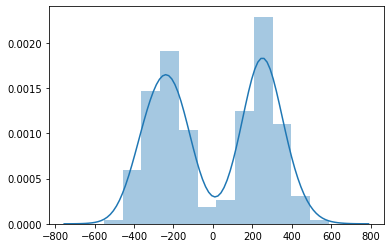

In [7]:
# Data
sigma = DIST_STD_DEV # mean and standard deviation
node_data = [np.array(x) for dist in [np.random.normal(CLUSTER_DISTANCE/2, sigma, int(NUM_NODES/2)), np.random.normal(-CLUSTER_DISTANCE/2, sigma, int(NUM_NODES/2))] for x in dist]
node_data.append
_ = sns.distplot(node_data)

In [8]:
# Tangle Initialization
tx_store = TempTransactionStore()
genesis = Transaction([])
# Initialize the genesis transaction with a number within the std dev interval
tx_store.save(genesis, np.array(random.uniform(-DIST_STD_DEV, DIST_STD_DEV)))
tangle = Tangle({genesis.id: genesis}, genesis.id)

In [9]:
# Results
num_txs = []     # Number of published transactions per round
consensus_c0 = []   # Value of consensus transaction per round cluster 0 (should converge to -250)
consensus_c1 = []   # Value of consensus transaction per round cluster 1 (should converge to 250)

In [16]:
for r in tqdm(range(NUM_ROUNDS)):
    txs = []

    for _ in range(NODES_PER_ROUND):
        node_id = np.random.randint(NUM_NODES)
        tip_selector = AccuracyTipSelector(tangle, tip_selection_settings)
        node = TheoreticalNode(tangle, tx_store, tip_selector, node_id, None, node_data[node_id])
        tx, tx_weights = node.create_transaction()

        if tx is not None:
            tx_store.save(tx, tx_weights)
            txs.append(tx)

    for tx in txs:
        tangle.add_transaction(tx)

    # Use two 'average' nodes (data=-250 and data=250) for validation
    reference_values_c0 = []
    tip_selector_c0 = AccuracyTipSelector(tangle, tip_selection_settings)
    validation_node_c0 = TheoreticalNode(tangle, tx_store, tip_selector_c0, 0, None, -CLUSTER_DISTANCE/2)
    for _ in range(int(VALIDATIONS_PER_ROUND)):
        _, reference = validation_node_c0.obtain_reference_params()
        reference_values_c0.append(reference)

    reference_values_c1 = []
    tip_selector_c1 = AccuracyTipSelector(tangle, tip_selection_settings)
    validation_node_c1 = TheoreticalNode(tangle, tx_store, tip_selector_c1, 0, None, CLUSTER_DISTANCE/2)
    for _ in range(int(VALIDATIONS_PER_ROUND)):
        _, reference = validation_node_c0.obtain_reference_params()
        reference_values_c1.append(reference)

    num_txs.append(len(txs))
    consensus_c0.append(reference_values_c0)
    consensus_c1.append(reference_values_c1)

100%|██████████| 150/150 [04:01<00:00,  1.61s/it]


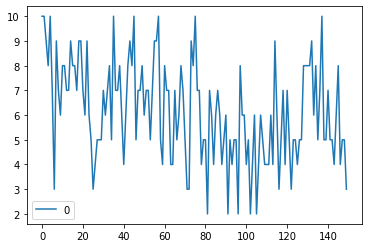

In [17]:
sns.lineplot(data=pd.DataFrame(num_txs))

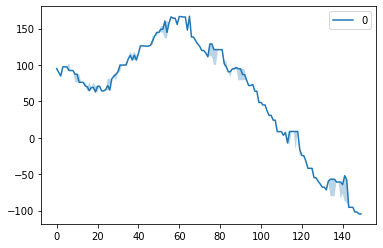

In [18]:
# Plot min max and median consensus values for each round
medians = pd.DataFrame([median(x) for x in consensus_c0])
mins = [min(x) for x in consensus_c0]
maxs = [max(x) for x in consensus_c0]
ax = sns.lineplot(data=medians)
ax.fill_between(medians.index, mins, maxs, alpha=0.3)

In [19]:
median(consensus_c0[-1]), min([abs(median(x)) for x in consensus_c0])

(-104.61931608575975, 3.3953548850251334)

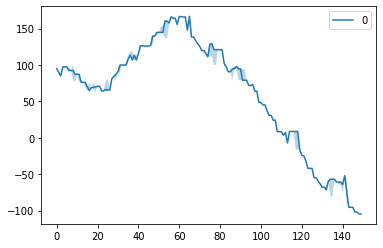

In [20]:
# Plot min max and median consensus values for each round
medians = pd.DataFrame([median(x) for x in consensus_c1])
mins = [min(x) for x in consensus_c1]
maxs = [max(x) for x in consensus_c1]
ax = sns.lineplot(data=medians)
ax.fill_between(medians.index, mins, maxs, alpha=0.3)

In [21]:
median(consensus_c1[-1]), min([abs(median(x)) for x in consensus_c1])

(-104.61931608575975, 3.3953548850251334)